# Lab 12: MCMC Tutorial

In this lab, we will study the 2D Ising model using Markov chain Monte Carlo.
We demonstrate how to implement the Metropolis-Hastings algorithm to sample the Ising model at different temperatures and study the phase transition.


## 2D Ising Model
The set of lattice sites is $\Lambda$, usually a square grid.
At each site, where $\sigma_k \in \{ -1, +1\}$￼is the spin at each site $k$.
For any two adjacent sites $\langle i j \rangle$ (with no double counting) there is a spin interaction $J$.
The energy of the system is given by

$$E(\sigma) = -J\sum_{\langle ij\rangle} \sigma_i\sigma_j$$

The probability of a given configuration $\sigma$ is given by the Boltzmann distribution

$$p(\sigma) = \frac{1}{Z}\exp \left(-\frac{E(\sigma)}{k_\mathrm{B}T}\right),$$

where $Z = \sum_{\sigma} \exp \left(-\frac{E(\sigma)}{k_\mathrm{B}T}\right)$ is the partition function, $T$ is the temperature, and $k_\mathrm{B}$ is the Boltzmann constant.
We assume periodic boundary conditions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

## Energy of a spin configuration

We will do a warmup problem by computing the energy of the Ising model spin configuration shown in lecture.
Blue squares represent spins pointing up, and red squares represent spins pointing down.
First, we initialize the lattice with the following spin configuration:

<img src="ising2d.png" width=300/>

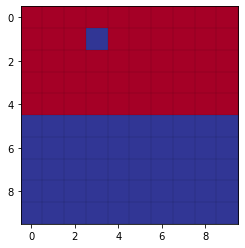

energy=-152.0


In [10]:
N = 10
J = 1
lattice_spins = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i < 5:
            lattice_spins[i, j] = -1
        else:
            lattice_spins[i, j] = 1
lattice_spins[1, 3] = 1


plt.figure()
plt.imshow(lattice_spins, cmap="RdYlBu")
# show gridlines
for i in range(N):
    plt.axhline(i + 0.5, color="black", lw=0.1)
    plt.axvline(i + 0.5, color="black", lw=0.1)
plt.show()

energy = 0
for i in range(N):
    for j in range(N):
        for k, l in [(-1, 0), (1, 0), (0, 1), (0, -1)]: #steps to take when navigating through the map, to obtain the sites of neighbors
            i_neigh = i + k if i + k < N else 0
            j_neigh = j + l if j + l < N else 0
            energy += -J * lattice_spins[i, j] * lattice_spins[i_neigh, j_neigh]
energy = energy / 2 #to avoid double counting
print(f"{energy=}")

## MCMC Sampling

As discussed in lecture, we will use the Metropolis-Hastings algorithm to sample the Ising model at a given temperature.

As discussed in class the critical temperature for the 2D Ising model is $T_\mathrm{c}=\frac{2}{\ln(1+\sqrt{2})}\approx 2.269$ in units where $J=k_\mathrm{B}=1$.
For $T<T_\mathrm{c}$, the system is in the ordered phase (spins tend to align), and for $T>T_\mathrm{c}$, the system is in the disordered phase. (The order parameter of this phase transition is M)

Let's start with $T=2$, a $100\times100$ lattice, and 1 million MCMC steps.

To apply the MCMC method to the Ising model, we design a Markov process using the Metropolis algorithm as follows
1. On step $k$, randomly choose one of the spins $\sigma_k$￼ and consider flipping it $\sigma_k \to -\sigma_k$.
2. Calculate the change in energy that would result from flipping spin $k$, i.e. the quantity:
$$\Delta E = - \left[J \sum_{\langle ij\rangle} \sigma_j\right] \Delta \sigma_i,$$
where $\Delta \sigma_i = -2\sigma_i$ is the change due to the spin flip
   -  If $\Delta E \leq 0$, accept the spin flip.
   -  If $\Delta E > 0$, accept the spin flip with probability $\exp(-\Delta E/k_\mathrm{B}T)$.
3. Update the moving average of whatever quantity we are interested in.
4. Repeat.

In [11]:
STEPS = 1_000_000
N = 100
J = 1
KB = 1
T = 2

# initialize random lattice
# lattice_spins = 2 * (np.random.randint(2, size=(N, N)) - 0.5)
# initialize ordered lattice with all spins up
lattice_spins = np.ones((N, N))

num_accept = 0
m_values = []
for t in tqdm.tqdm(range(STEPS)):
    i, j = np.random.randint(N), np.random.randint(N)
    # we only need to consider the neighbors of 
    # (i, j) to calculate the change in energy
    delta_energy = 0
    for k, l in [(-1, 0), (1, 0), (0, 1), (0, -1)]:
        i_neigh = i + k if i + k < N else 0
        j_neigh = j + l if j + l < N else 0
        delta_energy += -J * -2 * lattice_spins[i, j] * lattice_spins[i_neigh, j_neigh]
    if delta_energy <= 0:
        lattice_spins[i, j] *= -1
        num_accept += 1
    elif delta_energy > 0:
        prob = np.exp(-delta_energy / (KB * T))
        if np.random.random() < prob:
            lattice_spins[i, j] *= -1
            num_accept += 1
    m_values.append(np.mean(lattice_spins))

print(f"acceptance_rate = {num_accept/STEPS}")

100%|██████████| 1000000/1000000 [00:40<00:00, 24659.36it/s]

acceptance_rate = 0.07828


The final distribution of spins looks like this

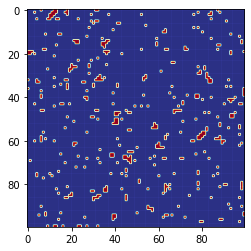

In [12]:
plt.figure()
plt.imshow(lattice_spins, cmap="RdYlBu")
# show gridlines
for i in range(N):
    plt.axhline(i + 0.5, color="black", lw=0.1)
    plt.axvline(i + 0.5, color="black", lw=0.1)
plt.show()

## Magnetization

We can measure the magnetization, defined as the average spin over the lattice

$$M = \frac{1}{N}\sum_{i=1}^N \sigma_i,$$

where $N$ is the number of spins.

Note we use a burn-in period of 100,000 steps to allow the system to reach equilibrium.

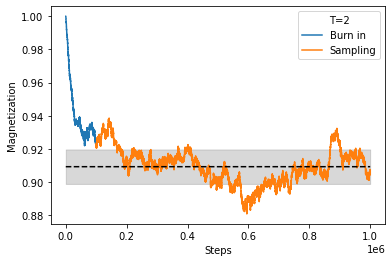

magnetization mean = 0.9092767166666668
magnetization std = 0.010390860600533632


In [13]:
BURNIN = 100_000

m_mean = np.mean(m_values[BURNIN:])
m_std = np.std(m_values[BURNIN:])

plt.figure()
plt.plot(range(STEPS)[:BURNIN], m_values[:BURNIN], label="Burn in")
plt.plot(range(STEPS)[BURNIN:], m_values[BURNIN:], label="Sampling")
# show mean as dashed line
plt.plot(range(STEPS), m_mean * np.ones((STEPS)), "--", color="black")
# show variance as filled box
plt.fill_between(range(STEPS), m_mean - m_std, m_mean + m_std, color="gray", alpha=0.3)
plt.xlabel("Steps")
plt.ylabel("Magnetization")
plt.legend(title=f"T={T}")
plt.show()

print(f"magnetization mean = {m_mean}")
print(f"magnetization std = {m_std}")

In [20]:
np.random.random()

0.7414002717756895